In [1]:
import os
import numpy as np
from nipype.interfaces import fsl
import nibabel as nib
import ants
import monai
from monai.transforms import LoadImage, Compose, SaveImage, ResizeWithPadOrCrop
import matplotlib.pyplot as plt

In [2]:
lddmm_registered_templates_folder = "/home/fehrdelt/data_ssd/data/lddmm_registered_templates/"

In [3]:
CLAMP_LOW_THRESHOLD = 1.5
CLAMP_HIGH_THRESHOLD = 80

### ANTS elastic registration


ANTS Default registration : 
“SyN”: Symmetric normalization: Affine + deformable transformation, with mutual information as optimization metric.



In [4]:
def downsample(path):
    
    img_orig = nib.load(path)
    img_downsampled = img_orig.get_fdata()[::2, ::2, ::2]
    empty_header = nib.Nifti1Header()
    img_downsampled_img = nib.Nifti1Image(img_downsampled, img_orig.affine, empty_header)
    nib.save(img_downsampled_img, path[:-7]+"_downsampled.nii.gz")
    

In [5]:
def clamp_values(image, low_threshold, high_threshold):
    new_img = image.copy()
    
    new_img[new_img < low_threshold] = 0
    new_img[new_img > high_threshold] = high_threshold
    return new_img

In [6]:
def histogram_matching(target, source):
    n_bins = 100
    # Calcul des histogrammes et des fonctions de répartition cumulée
    mask_target = target > 1e-5
    hist_target, edge_bin_T = np.histogram(target[mask_target], bins=n_bins, density=True)
    cdf_target = hist_target.cumsum()
    # ic(hist_target,edge_bin_T, cdf_target)

    hist_source, edge_bin_S = np.histogram(source[source > 0], bins=n_bins, density=True)
    cdf_source = hist_source.cumsum()
    
    # Création de la nouvelle image
    new_T = np.zeros_like(target)
    for i, (gt_m, gt_M) in enumerate(zip(edge_bin_T[:-1], edge_bin_T[1:])):
        gs = np.argmin(np.abs(cdf_target[i] - cdf_source))
        mask_gt = np.logical_and((target > gt_m), (target < gt_M))
        np.putmask(new_T, mask_gt, (gs / n_bins))

    plt.show()
    new_T[~mask_target] = 0
    return new_T

In [7]:
# on garde les sources (templates) registered en FLIRT que j'ai fait pour le LDDMM




registered_templates_folder = "/home/fehrdelt/data_ssd/data/templates_FLIRT_registered/"

for file in os.listdir(registered_templates_folder):
    if "downsampled" in file and file.endswith(".nii.gz"):

        source_name = registered_templates_folder+file
        #source_name = "/home/fehrdelt/data_ssd/data/TEMPLATE_miplab-ncct_sym_brain.nii.gz"
        target_name = "/home/fehrdelt/data_ssd/data/SkullStripped_ground_truth/"+file[:11]+"_SkullStripped_clean_reshape_downsampled.nii.gz"
        
        img_target = nib.load(target_name)
        img_target_data = img_target.get_fdata()
        
        img_target_data = clamp_values(img_target_data, CLAMP_LOW_THRESHOLD, CLAMP_HIGH_THRESHOLD)
        img_target_data = img_target_data/np.max(img_target_data)
        
        
        img_source = nib.load(source_name)
        img_source_data = img_source.get_fdata()
        
        img_source_data = clamp_values(img_source_data, CLAMP_LOW_THRESHOLD, CLAMP_HIGH_THRESHOLD)
        img_source_data = img_source_data/np.max(img_source_data)
        
        img_target_data = histogram_matching(img_target_data, img_source_data)
        
        
        new_img_target = nib.Nifti1Image(img_target_data, img_target.affine, img_target.header)
        new_img_source = nib.Nifti1Image(img_source_data, img_source.affine, img_source.header)
        
        nib.save(new_img_target, "/home/fehrdelt/data_ssd/data/ants_histogram_matching_temp/"+file[:11]+"_SkullStripped_clean_reshape_downsampled.nii.gz")
        nib.save(new_img_source, "/home/fehrdelt/data_ssd/data/ants_histogram_matching_temp/"+file)        
        
        
        
        img_target = ants.image_read("/home/fehrdelt/data_ssd/data/ants_histogram_matching_temp/"+file[:11]+"_SkullStripped_clean_reshape_downsampled.nii.gz")
        img_source = ants.image_read("/home/fehrdelt/data_ssd/data/ants_histogram_matching_temp/"+file)

        

        
        
        reg = ants.registration(img_target, img_source, outprefix="/home/fehrdelt/data_ssd/data/templates_ANTS_registered_histogram_matching/"+file[:11], random_seed=42)
        reg['warpedmovout'].to_file("/home/fehrdelt/data_ssd/data/templates_ANTS_registered_histogram_matching/"+file[:11]+".nii.gz")
        

### Mean squared error

Between the elastically registered template and the target (manually extracted brain ground truth)

In [8]:
def compute_MSE(registered_template_path, target_path):
    # this method first clamps and normalizes the image values
    # and then computes the mean squared error



    #templates have already been normalized
    template_data = nib.load(registered_template_path).get_fdata()
    template_shape = template_data.shape
    
    resize_transform = Compose([LoadImage(image_only=True, ensure_channel_first=True)])
                               #   ResizeWithPadOrCrop(template_shape, mode="median")
                               
    resized_target_data = resize_transform(target_path)

    resized_target_data = clamp_values(resized_target_data.numpy(), CLAMP_LOW_THRESHOLD, CLAMP_HIGH_THRESHOLD)
    
    
    resized_target_data = resized_target_data/np.max(resized_target_data)
    
    MSE = np.square(np.subtract(resized_target_data, template_data)).mean() 
    return MSE

In [9]:
LDDMM_MSE_dict = {}

lddmm_registered_templates_folder = "/home/fehrdelt/data_ssd/data/lddmm_registered_templates/"

for file in os.listdir(lddmm_registered_templates_folder):
    if file.endswith(".nii.gz"):

        registered_lddmm_template_path = lddmm_registered_templates_folder+file
        target_path = "/home/fehrdelt/data_ssd/data/SkullStripped_ground_truth/"+file[:11]+"_SkullStripped_clean_reshape_downsampled.nii.gz"
        
        
        
        LDDMM_MSE_dict[file[:11]] = compute_MSE(registered_lddmm_template_path, target_path)
        

ANTS_MSE_dict = {}

ants_registered_templates_folder = "/home/fehrdelt/data_ssd/data/templates_ANTS_registered/"

for file in os.listdir(ants_registered_templates_folder):
    if file.endswith(".nii.gz") and len(file)==18:

        registered_ants_template_path = ants_registered_templates_folder+file
        target_path = "/home/fehrdelt/data_ssd/data/SkullStripped_ground_truth/"+file[:11]+"_SkullStripped_clean_reshape_downsampled.nii.gz"
        
        
        
        ANTS_MSE_dict[file[:11]] = compute_MSE(registered_ants_template_path, target_path)
        

ANTS_MSE_histogram_matching_dict = {}

ants_histogram_matching_registered_templates_folder = "/home/fehrdelt/data_ssd/data/templates_ANTS_registered_histogram_matching/"

for file in os.listdir(ants_histogram_matching_registered_templates_folder):
    if file.endswith(".nii.gz") and len(file)==18:

        registered_ants_histogram_matching_template_path = ants_histogram_matching_registered_templates_folder+file
        target_path = "/home/fehrdelt/data_ssd/data/SkullStripped_ground_truth/"+file[:11]+"_SkullStripped_clean_reshape_downsampled.nii.gz"
        
        
        
        ANTS_MSE_histogram_matching_dict[file[:11]] = compute_MSE(registered_ants_histogram_matching_template_path, target_path)
        


In [10]:
print("LDDMM registration MSE mean over all images")
LDDMM_MSE_mean = np.mean(list(LDDMM_MSE_dict.values()))
print(LDDMM_MSE_mean)
print("ANTS registration MSE mean over all images")
ANTS_MSE_mean = np.mean(list(ANTS_MSE_dict.values()))
print(ANTS_MSE_mean)
print("ANTS with histogram matching registration MSE mean over all images")
ANTS_MSE_histogram_matching_mean = np.mean(list(ANTS_MSE_histogram_matching_dict.values()))
print(ANTS_MSE_histogram_matching_mean)



LDDMM registration MSE mean over all images
0.002440018879452757
ANTS registration MSE mean over all images
0.0026276893605672452
ANTS with histogram matching registration MSE mean over all images
0.0020888312920099576


In [11]:
patients_list = ["orig_J1_P01"]

for patient in patients_list:
    print("LDDMM: ")
    print(LDDMM_MSE_dict[patient])
    print("ANTS: ")
    print(ANTS_MSE_dict[patient])
    print("\n\n")


LDDMM: 
0.0021594300081617286
ANTS: 
0.0017521918226695175





### Visualiser

Text(0.5, 0, 'target')

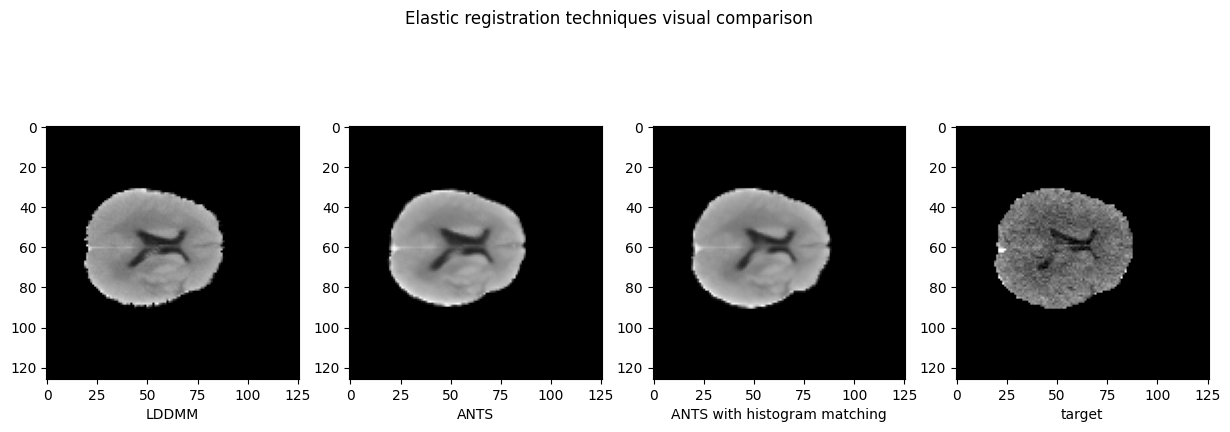

In [12]:
lddmm_registered_template = nib.load(lddmm_registered_templates_folder+"orig_J1_P02_lddmm_registered.nii.gz").get_fdata()
lddmm_registered_template_section = lddmm_registered_template[:, :, int(lddmm_registered_template.shape[2]/1.7)]

ants_registered_template = nib.load(ants_registered_templates_folder+"orig_J1_P02.nii.gz").get_fdata()
ants_registered_template_section = ants_registered_template[:, :, int(ants_registered_template.shape[2]/1.7)]

ants_histogram_matching_registered_template = nib.load(ants_histogram_matching_registered_templates_folder+"orig_J1_P02.nii.gz").get_fdata()
ants_histogram_matching_registered_template_section = ants_histogram_matching_registered_template[:, :, int(ants_histogram_matching_registered_template.shape[2]/1.7)]


target = nib.load("/home/fehrdelt/data_ssd/data/SkullStripped_ground_truth/orig_J1_P02_SkullStripped_clean_reshape_downsampled.nii.gz").get_fdata()
target = clamp_values(target, CLAMP_LOW_THRESHOLD, CLAMP_HIGH_THRESHOLD)
target = target/np.max(target)
target_section = target[:, :, int(target.shape[2]/1.7)]

plt.rcParams["figure.figsize"] = (15,5)

fig, axs = plt.subplots(1,4)

fig.suptitle("Elastic registration techniques visual comparison")

#  axs[line, column]
axs[0].imshow(lddmm_registered_template_section, cmap="gray")
axs[0].set_xlabel("LDDMM")

axs[1].imshow(ants_registered_template_section, cmap="gray")
axs[1].set_xlabel("ANTS")

axs[2].imshow(ants_histogram_matching_registered_template_section, cmap="gray")
axs[2].set_xlabel("ANTS with histogram matching")

axs[3].imshow(target_section, cmap="gray")
axs[3].set_xlabel("target")


